**Dorothea Claresta P (18318007)**

# **Importing Library**

In [ ]:
import torch
import os
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import time
import copy
import torch.optim as optim
torch.cuda.empty_cache()
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose
from torch.utils.data import ConcatDataset
import pandas as pd

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

# **Getting NISN Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive2', force_remount=True)

Mounted at /content/drive2


# **Training and Validation Datasets**

## **Defining Dataset**

In [ ]:
fold = 10 # no. of kfold
img_size = 320

train_ds_list = []
for i in range(1, 11):
  if i != fold:
    train_ds_i = ImageFolder(
        '/content/drive2/MyDrive/10folds/fold'+str(i)+'/',
        transform=Compose([Resize((img_size, img_size)),
                           ToTensor()]))
    print('Jumlah train dataset dari fold %d: %d' % (i, len(train_ds_i)))
    train_ds_list.append(train_ds_i)

train_ds = ConcatDataset(train_ds_list)
print('\nJumlah train dataset total: %d' % len(train_ds))

val_ds = ImageFolder(
    '/content/drive2/MyDrive/10folds/fold'+str(fold)+'/',
    transform=Compose([Resize((img_size, img_size)),
                        ToTensor()]))
print('Jumlah val dataset (fold %d): %d' % (fold, len(val_ds)))

Jumlah train dataset dari fold 1: 528
Jumlah train dataset dari fold 2: 529
Jumlah train dataset dari fold 3: 529
Jumlah train dataset dari fold 4: 528
Jumlah train dataset dari fold 5: 528
Jumlah train dataset dari fold 6: 529
Jumlah train dataset dari fold 7: 528
Jumlah train dataset dari fold 8: 528
Jumlah train dataset dari fold 9: 529

Jumlah train dataset total: 4756
Jumlah val dataset (fold 10): 529


## **Data Loaders for Training and Validation**

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size = 40

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## **Showing Batch in Grid**

In [ ]:
# from torchvision.utils import make_grid

# def show_batch(dl):
#     for images, labels in dl:
#         fig, ax = plt.subplots(figsize=(12, 6))
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
#         break

# show_batch(train_dl)

# **Model & Helper Function**

## **Model Architecture**

In [ ]:
"""
Creates a MobileNetV3 Model as defined in:
Andrew Howard, Mark Sandler, Grace Chu, Liang-Chieh Chen, Bo Chen, Mingxing Tan, Weijun Wang, Yukun Zhu, Ruoming Pang, Vijay Vasudevan, Quoc V. Le, Hartwig Adam. (2019).
Searching for MobileNetV3
arXiv preprint arXiv:1905.02244.

https://github.com/d-li14/mobilenetv3.pytorch/blob/master/mobilenetv3.py
"""

import torch.nn as nn
import math


__all__ = ['mobilenetv3_large', 'mobilenetv3_small']


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se, use_hs):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup

        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV3(nn.Module):
    def __init__(self, cfgs, mode, in_channels=3, use_auxiliary=False, num_classes=37, width_mult=1.):
        super(MobileNetV3, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = cfgs
        assert mode in ['large', 'small']

        # building first layer
        input_channel = _make_divisible(16 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            layers.append(block(input_channel, exp_size, output_channel, k, s, use_se, use_hs))
            input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        self.conv = conv_1x1_bn(input_channel, exp_size)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_channel = {'large': 1280, 'small': 1024}
        output_channel = _make_divisible(output_channel[mode] * width_mult, 8) if width_mult > 1.0 else output_channel[mode]
        self.classifier = nn.Sequential(
            nn.Linear(exp_size, output_channel),
            h_swish(),
            nn.Dropout(0.2),
            nn.Linear(output_channel, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def mobilenetv3_large(**kwargs):
    """
    Constructs a MobileNetV3-Large model
    """
    cfgs = [
        # k, t, c, SE, HS, s 
        [3,   1,  16, 0, 0, 1],
        [3,   4,  24, 0, 0, 2],
        [3,   3,  24, 0, 0, 1],
        [5,   3,  40, 1, 0, 2],
        [5,   3,  40, 1, 0, 1],
        [5,   3,  40, 1, 0, 1],
        [3,   6,  80, 0, 1, 2],
        [3, 2.5,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [5,   6, 160, 1, 1, 2],
        [5,   6, 160, 1, 1, 1],
        [5,   6, 160, 1, 1, 1]
    ]
    return MobileNetV3(cfgs, mode='large', **kwargs)


def mobilenetv3_small(**kwargs):
    """
    Constructs a MobileNetV3-Small model
    """
    cfgs = [
        # k, t, c, SE, HS, s 
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  40, 1, 1, 2],
        [5,    6,  40, 1, 1, 1],
        [5,    6,  40, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    6,  96, 1, 1, 2],
        [5,    6,  96, 1, 1, 1],
        [5,    6,  96, 1, 1, 1],
    ]

    return MobileNetV3(cfgs, mode='small', **kwargs)


## **Train Function**

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50):
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_time = time.time()
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']: # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # Iterate over data
                
                inputs = inputs.to(device)

                labels = labels.to(device)

                optimizer.zero_grad() # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train
                    
                    if phase == 'train': # Backward + optimize only if in training phase
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                            
                        _, preds = torch.max(outputs, 1)
                        loss.backward()
                        optimizer.step()
                    
                    if phase == 'val':
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            if phase == 'val': # Adjust learning rate based on val loss
                lr_scheduler.step(epoch_loss)
                
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

        epoch_time_elapsed = time.time() - epoch_time
        print('{:.0f}m {:.0f}s\n'.format(epoch_time_elapsed // 60, epoch_time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accs, val_losses, val_accs

## **Defining Model**

In [ ]:
model = mobilenetv3_large()
model.to(device)
next(model.parameters()).is_cuda

True

# **Training**

## **Initial Accuracy and Loss on Val. Dataset**

In [ ]:
criterion = nn.CrossEntropyLoss()

model.eval().cuda()

run_loss = 0
correct = 0
with  torch.no_grad():
    for inputs, labels in val_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        # Make predictions.
        prediction = model(inputs)

        # Retrieve predictions indexes.
        loss = criterion(prediction.data, labels)
        _, predicted_class = torch.max(prediction.data, 1)

        # Compute number of correct predictions.
        run_loss += loss.item() * inputs.size(0)
        correct += (predicted_class == labels).float().sum().item()

val_loss = run_loss / len(val_dl.dataset)
val_accuracy = correct / len(val_dl.dataset)
print('Val Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Val Loss: 3.6109 Acc: 0.3308


## **Training**

In [ ]:
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [ ]:
model, train_losses, train_accs, val_losses, val_accs = train_model(model, {"train": train_dl, "val": val_dl}, criterion, optimizer, epochs)

Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.5854 Acc: 0.3219
val Loss: 2.4835 Acc: 0.3100
10m 30s

Epoch 2/100
----------
train Loss: 2.3709 Acc: 0.3370
val Loss: 2.4626 Acc: 0.3289
1m 22s

Epoch 3/100
----------
train Loss: 2.1413 Acc: 0.3707
val Loss: 2.3684 Acc: 0.3100
1m 22s

Epoch 4/100
----------
train Loss: 1.9387 Acc: 0.4151
val Loss: 2.2908 Acc: 0.3138
1m 22s

Epoch 5/100
----------
train Loss: 1.7013 Acc: 0.4712
val Loss: 2.1712 Acc: 0.3686
1m 22s

Epoch 6/100
----------
train Loss: 1.4533 Acc: 0.5275
val Loss: 1.7390 Acc: 0.4499
1m 22s

Epoch 7/100
----------
train Loss: 1.2696 Acc: 0.5839
val Loss: 1.6823 Acc: 0.4764
1m 22s

Epoch 8/100
----------
train Loss: 1.0207 Acc: 0.6613
val Loss: 1.9799 Acc: 0.4518
1m 21s

Epoch 9/100
----------
train Loss: 0.8942 Acc: 0.6974
val Loss: 1.0047 Acc: 0.6616
1m 21s

Epoch 10/100
----------
train Loss: 0.7006 Acc: 0.7778
val Loss: 1.1017 Acc: 0.6749
1m 22s

Epoch 11/100
----------
train Loss: 0.6088 Acc: 0.7979
val Loss: 1.0770 Acc: 0.6692
1m 22s

Epoch 12/100
------

## **Final Accuracy and Loss on Val. Dataset**

In [ ]:
criterion = nn.CrossEntropyLoss()

model.eval().cuda()

run_loss = 0
correct = 0
with  torch.no_grad():
    for inputs, labels in val_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        # Make predictions.
        prediction = model(inputs)

        # Retrieve predictions indexes.
        loss = criterion(prediction.data, labels)
        _, predicted_class = torch.max(prediction.data, 1)

        # Compute number of correct predictions.
        run_loss += loss.item() * inputs.size(0)
        correct += (predicted_class == labels).float().sum().item()

val_loss = run_loss / len(val_dl.dataset)
val_accuracy = correct / len(val_dl.dataset)
print('Val Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Val Loss: 0.4639 Acc: 0.9036


# **Save / Load Model**

## **Saving Model**

In [ ]:
torch.save(model.state_dict(), '/content/model_fold'+str(fold)+'.pt')

## **Loading Model**

In [ ]:
device = torch.device("cuda")
model = mobilenetv3_large()
model.load_state_dict(torch.load('/content/model_fold'+str(fold)+'.pt', map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): h_swish(
        (sigmoid): h_sigmoid(
          (relu): ReLU6(inplace=True)
        )
      )
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Identity()
        (4): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e

# **Plot Loss & Accuracy**

## **Plot Loss vs No. of Epochs**

0.463922724155938


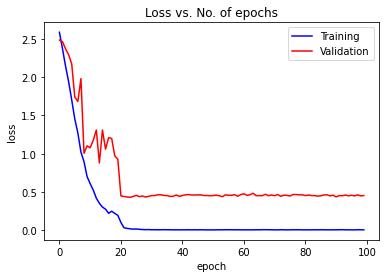

In [ ]:
plt.plot(train_losses, '-b')
plt.plot(val_losses, '-r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');

plt.savefig('plot_loss'+str(fold)+'.png')
print(val_loss)

## **Plot Accuracy vs No. of Epochs**

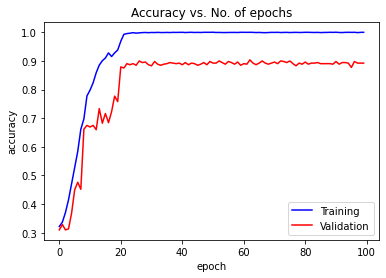

In [ ]:
plt.plot(train_accs, '-b')
plt.plot(val_accs, '-r')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy vs. No. of epochs');

plt.savefig('plot_acc'+str(fold)+'.png')

## **Plot Print**

In [ ]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for i in range(epochs):
  # train_loss_list.append(train_loss[i].item())
  train_acc_list.append(train_accs[i].item())
  # val_loss_list.append(val_loss[i].item())
  val_acc_list.append(val_accs[i].item())

data = {'train_loss': train_losses, 'train_acc': train_acc_list,
        'val_loss': val_losses, 'val_acc': val_acc_list}

df = pd.DataFrame(data)
df.to_csv('data_fold'+str(fold)+'.csv')
df

,train_loss,train_acc,val_loss,val_acc
0,2.585410,0.321909,2.483520,0.310019
1,2.370892,0.337048,2.462643,0.328922
2,2.141322,0.370690,2.368378,0.310019
3,1.938659,0.415055,2.290846,0.313800
4,1.701299,0.471194,2.171247,0.368620
...,...,...,...,...
95,0.005103,0.999579,0.458050,0.877127
96,0.005149,0.999790,0.448897,0.897921
97,0.007132,0.998738,0.462683,0.892250
98,0.006662,0.999579,0.448415,0.892250
